# Diabetes Prediction - Logistic Regression

**Notebook Series**:
['1_eda.ipynb](./1_eda.ipynb) --> ['2_preprocessing.ipynb'](./2_preprocessing.ipynb) --> **3a_logistic_regression.ipynb**

# Libraries & path

In [61]:
import sys
import os
from pathlib import Path
from joblib import load

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import shap  
import time

# add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Load preprocessed data

In [2]:
# Load preprocessed data
X_train = pd.read_pickle('../data/processed/X_train.pkl')
y_train = pd.read_pickle('../data/processed/y_train.pkl')

X_test = pd.read_pickle('../data/processed/X_test.pkl')
y_test = pd.read_pickle('../data/processed/y_test.pkl')

In [3]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'\nX_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (614, 24)
y_train shape: (614,)

X_test shape: (154, 24)
y_test shape: (154,)


## Confirm the data contains no NaN or inf values

In [4]:
print("NaN in X_train:", X_train.isna().sum().sum())
print("NaN in X_test:", X_test.isna().sum().sum())
print("Infinity in X_train:", np.isinf(X_train).sum().sum())
print("Infinity in X_test:", np.isinf(X_test).sum().sum())

NaN in X_train: 0
NaN in X_test: 0
Infinity in X_train: 0
Infinity in X_test: 0


# Logistic Regression Model

In [37]:
logreg = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
)

## LR model with default parameters

In [38]:
# Besides the max_iter, class_weight, and random_state, I will fit the train data and predict with an otherwise default logistic regression model

# fit
base_lr_model = logreg.fit(X_train, y_train)

# predict
y_train_pred_baselr = base_lr_model.predict(X_train)
y_test_pred_baselr = base_lr_model.predict(X_test)

# get prediction probabilities 
y_train_proba_baselr = base_lr_model.predict_proba(X_train)
y_test_proba_baselr = base_lr_model.predict_proba(X_test)

## Base LR model performance metrics

In [39]:
# AUC score 

print(f'AUC score for the logistic regression model with default parameters')
print(f'Train data: {roc_auc_score(y_train, y_train_proba_baselr[:,1]):.3f}')
print(f'Test data: {roc_auc_score(y_test, y_test_proba_baselr[:,1]):.3f}')

AUC score for the logistic regression model with default parameters
Train data: 0.861
Test data: 0.821


In [40]:
# classification report 

print('classification report for the base logistic regression model')
print(f'\ntraining data: \n{classification_report(y_train, y_train_pred_baselr)}')
print(f'\ntest data: \n{classification_report(y_test, y_test_pred_baselr)}')

classification report for the base logistic regression model

training data: 
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       401
           1       0.63      0.80      0.70       213

    accuracy                           0.77       614
   macro avg       0.75      0.77      0.75       614
weighted avg       0.79      0.77      0.77       614


test data: 
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        99
           1       0.58      0.78      0.67        55

    accuracy                           0.72       154
   macro avg       0.72      0.73      0.71       154
weighted avg       0.75      0.72      0.73       154



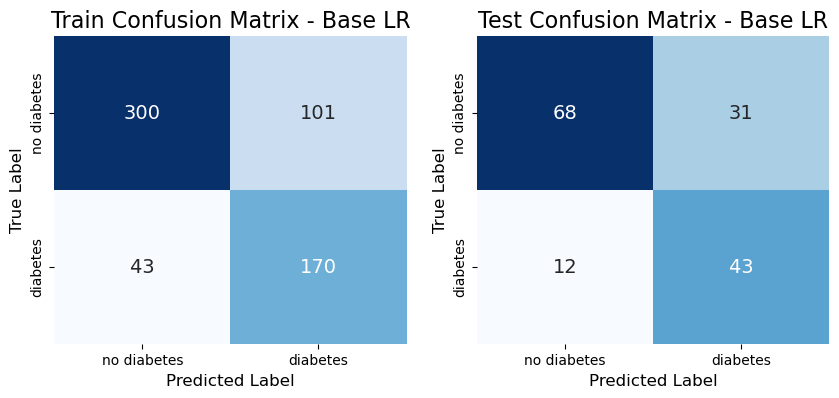

In [41]:
# confusion matrix

cm_baselr_train = confusion_matrix(y_train, y_train_pred_baselr)
cm_baselr_test = confusion_matrix(y_test, y_test_pred_baselr)

fig, axs = plt.subplots(1,2, figsize=(10,4))

sns.heatmap(
    cm_baselr_train, 
    annot=True, fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=['no diabetes','diabetes'],
    yticklabels=['no diabetes','diabetes'],
    annot_kws={'size':14},
    ax=axs[0]
)
axs[0].set_title('Train Confusion Matrix - Base LR', fontsize=16)
axs[0].set_xlabel('Predicted Label', fontsize=12)
axs[0].set_ylabel('True Label', fontsize=12)
axs[0].tick_params(axis='both', labelsize=10)

sns.heatmap(
    cm_baselr_test, 
    annot=True, fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=['no diabetes','diabetes'],
    yticklabels=['no diabetes','diabetes'],
    annot_kws={'size':14},
    ax=axs[1]
)
axs[1].set_title('Test Confusion Matrix - Base LR', fontsize=16)
axs[1].set_xlabel('Predicted Label', fontsize=12)
axs[1].set_ylabel('True Label', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)

Definitions:
- AUC = 'Area Under the Curve".  It is a measure of the model's ability to discriminate between classes.
- Precision = TP / (TP + FP): how many predicted positives are actual positives.
- Recall = TP / (TP + FN): how many actual positives were caught.
- F1-score = harmonic mean of precision and recall.


The AUC scores are solid for a default model without overfitting, suggesting that the model has descent discriminatory power.

Classification report:

training data - The recall score is a bit low for class 0 (no diabetes) at 0.75 suggesting that the model misses a fair number of people without diabetes.  However, the recall score of 0.80 for class 1 (diabetes) isn't bad.  

Test data - the recall doesn't drop much for the test set and the overall accuracy stays reasonbly close to the training data as well (0.77 vs 0.72).  So the model in generalizing well.  However there is an increase in false positives as indicated by the lower precision score compared to the training set (0.58 vs 0.63).

Overall, decent recall for diabetes could allow for productive screening.  However, the number of false positives is a bit high and should be improved upon.  

## Hyperparameter tuning with gridsearch

In [46]:
# perform a grid search to find the best hyperparameters for the logistic regression model

parameters_l1 = {
    'C':[500, 550, 600, 1000],
    'penalty':['l1'],
    'solver':['liblinear','saga']
}

parameters_l2 = {
    'C':[0.05, 0.075, 0.1, 0.15, 0.2, 0.5],
    'penalty':['l2'],
    'solver':['liblinear','saga','newton-cg','lbfgs']
}

# Use StratifiedKFold for better handling of class imbalance
cv = StratifiedKFold(n_splits=10)

gs_l1 = GridSearchCV(
    estimator=logreg,
    param_grid=parameters_l1,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gs_l2 = GridSearchCV(
    estimator=logreg,
    param_grid=parameters_l2,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# get the start time
start_time = time.time()

gs_l1.fit(X_train,y_train)
gs_l2.fit(X_train,y_train)

# get the end and elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# best score and parameters
best_aucscore_l1_lr = gs_l1.best_score_
best_parameters_l1_lr = gs_l1.best_params_

best_aucscore_l2_lr = gs_l2.best_score_
best_parameters_l2_lr = gs_l2.best_params_

best_model_l1_lr = gs_l1.best_estimator_
best_model_l2_lr = gs_l2.best_estimator_

print(f'\nL1 penalty AUC score: {best_aucscore_l1_lr:.2f}')
print(f'\nL1 penalty best parameters: \n{best_parameters_l1_lr}')
print(f'\nL2 penalty AUC score: {best_aucscore_l2_lr:.2f}')
print(f'\nL2 penalty best parameters: \n{best_parameters_l2_lr}')

print(f'\nelapsed time: {elapsed_time:.2f} seconds')

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 24 candidates, totalling 240 fits

L1 penalty AUC score: 0.85

L1 penalty best parameters: 
{'C': 600, 'penalty': 'l1', 'solver': 'liblinear'}

L2 penalty AUC score: 0.85

L2 penalty best parameters: 
{'C': 0.05, 'penalty': 'l2', 'solver': 'saga'}

elapsed time: 8.36 seconds


## Tuned LR model metrics

In [50]:
# apply the gridsearch best parameters to predict the independent variable (diabetes)

# l1 regularization
y_train_pred_l1 = gs_l1.predict(X_train)
y_test_pred_l1 = gs_l1.predict(X_test)

y_train_proba_l1 = gs_l1.predict_proba(X_train)
y_test_proba_l1 = gs_l1.predict_proba(X_test)

# l2 regularization
y_train_pred_l2 = gs_l2.predict(X_train)
y_test_pred_l2 = gs_l2.predict(X_test)

y_train_proba_l2 = gs_l2.predict_proba(X_train)
y_test_proba_l2 = gs_l2.predict_proba(X_test)

print(f'train ROC-AUC score default parameters: {roc_auc_score(y_train, y_train_proba_baselr[:,1]):.3f}')
print(f'test ROC-AUC score default parameters: {roc_auc_score(y_test, y_test_proba_baselr[:,1]):.3f}')
print(f'\ntrain ROC-AUC score L1 penalty: {roc_auc_score(y_train,y_train_proba_l1[:,1]):.3f}')
print(f'test ROC-AUC score L1 penalty: {roc_auc_score(y_test,y_test_proba_l1[:,1]):.3f}')
print(f'\ntrain ROC-AUC score, L2 penalty: {roc_auc_score(y_train,y_train_proba_l2[:,1]):.3f}')
print(f'test ROC-AUC score, L2 penalty: {roc_auc_score(y_test,y_test_proba_l2[:,1]):.3f}')

train ROC-AUC score default parameters: 0.861
test ROC-AUC score default parameters: 0.821

train ROC-AUC score L1 penalty: 0.866
test ROC-AUC score L1 penalty: 0.831

train ROC-AUC score, L2 penalty: 0.857
test ROC-AUC score, L2 penalty: 0.819


The logistic regression model with l1 regularization (C = 600) and liblinear solver slightly improved the AUC score.  The gridsearch results with l2 regularization are slightly worse than the default AUC metrics.  

In [52]:
# classification reports for default and tuned models

print('classification report for the base logistic regression model')
print(f'\ntraining data: \n{classification_report(y_train, y_train_pred_baselr)}')
print(f'\ntest data: \n{classification_report(y_test, y_test_pred_baselr)}')

# classification report for tuned LR model with L1 penalty
print(f'\nclassification report for tuned logistic regression model with L1 reg')
print(f'\ntrain data, L1: \n{classification_report(y_train,y_train_pred_l1)}')
print(f'\ntest data, L1: \n{classification_report(y_test,y_test_pred_l1)}')

# classification report for tuned LR model with L2 penalty
print(f'\nclassification report for tuned logistic regression model with L2 reg')
print(f'\ntrain data, L2: \n{classification_report(y_train,y_train_pred_l2)}')
print(f'\ntest data, L2: \n{classification_report(y_test,y_test_pred_l2)}')

classification report for the base logistic regression model

training data: 
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       401
           1       0.63      0.80      0.70       213

    accuracy                           0.77       614
   macro avg       0.75      0.77      0.75       614
weighted avg       0.79      0.77      0.77       614


test data: 
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        99
           1       0.58      0.78      0.67        55

    accuracy                           0.72       154
   macro avg       0.72      0.73      0.71       154
weighted avg       0.75      0.72      0.73       154


classification report for tuned logistic regression model with L1 reg

train data, L1: 
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       401
           1       0.63      0.78      0.70       213

  

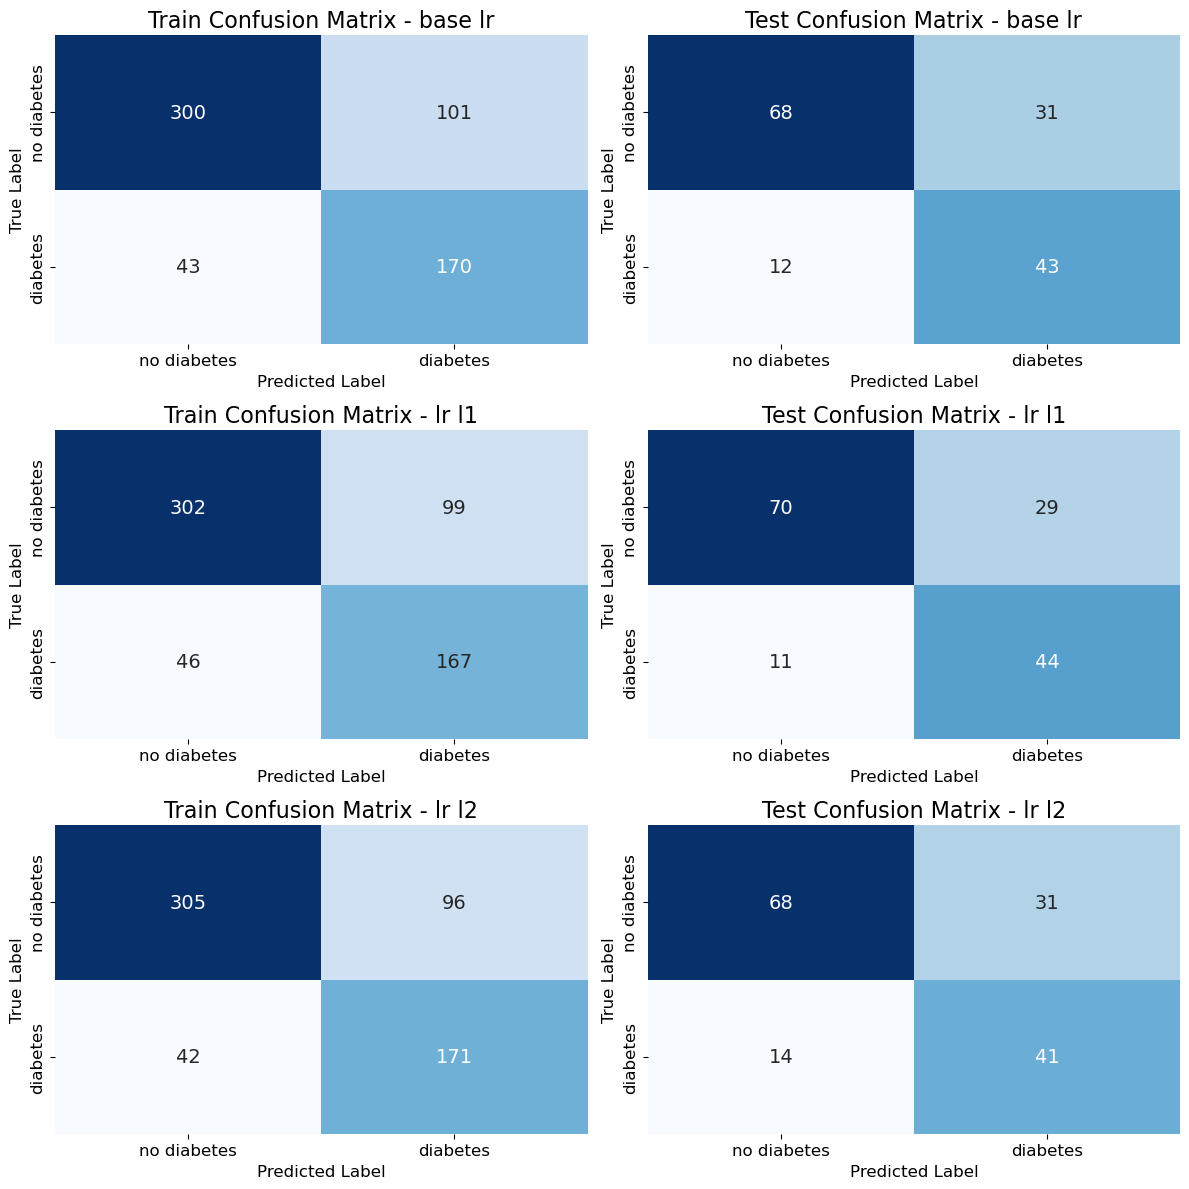

In [57]:
# confusion matrices

# define models
models = [
    ('base lr', y_train_pred_baselr, y_test_pred_baselr),
    ('lr l1', y_train_pred_l1, y_test_pred_l1),
    ('lr l2', y_train_pred_l2, y_test_pred_l2)
]

# create subplots
fig, axs = plt.subplots(3,2, figsize=(12,12))

# common axis labels
xticklabels = ['no diabetes', 'diabetes']
yticklabels = ['no diabetes', 'diabetes']

for i, (name, y_pred_train, y_pred_test) in enumerate(models):
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # train plot
    sns.heatmap(
        cm_train,
        annot=True, fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        annot_kws={'size':14},
        ax=axs[i,0]
    )

    axs[i,0].set_title(f'Train Confusion Matrix - {name}', fontsize=16)
    axs[i,0].set_xlabel('Predicted Label', fontsize=12)
    axs[i,0].set_ylabel('True Label', fontsize=12)
    axs[i,0].tick_params(axis='both', labelsize=12)

    # test plot
    sns.heatmap(
        cm_test,
        annot=True, fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        annot_kws={'size':14},
        ax=axs[i,1]
    )

    axs[i,1].set_title(f'Test Confusion Matrix - {name}', fontsize=16)
    axs[i,1].set_xlabel('Predicted Label', fontsize=12)
    axs[i,1].set_ylabel('True Label', fontsize=12)
    axs[i,1].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

In [76]:
print(f'confusion matrix for the logistic regression model with default parameters')
print(f'\ntrain data: \n{confusion_matrix(y_train,y_train_pred_baselr)}')
print(f'\ntest data: \n{confusion_matrix(y_test,y_test_pred_baselr)}')

print(f'\nconfusion matrix for tuned LR l1 model')
print(f'\ntrain data: \n{confusion_matrix(y_train,y_train_pred_l1)}')
print(f'\ntest data: \n{confusion_matrix(y_test,y_test_pred_l1)}')

print(f'\nconfusion matrix for tuned LR l2 model')
print(f'\ntrain data: \n{confusion_matrix(y_train,y_train_pred_l2)}')
print(f'\ntest data: \n{confusion_matrix(y_test,y_test_pred_l2)}')

confusion matrix for the logistic regression model with default parameters

train data: 
[[300 101]
 [ 43 170]]

test data: 
[[68 31]
 [12 43]]

confusion matrix for tuned LR l1 model

train data: 
[[302  99]
 [ 46 167]]

test data: 
[[70 29]
 [11 44]]

confusion matrix for tuned LR l2 model

train data: 
[[305  96]
 [ 42 171]]

test data: 
[[68 31]
 [14 41]]


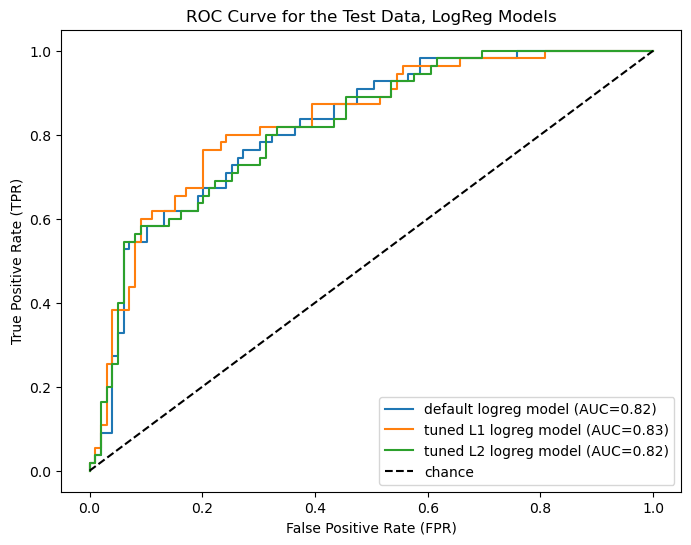

In [75]:
# ROC curves of the test data for three logistic regression models
fpr_lr,tpr_lr,_ = roc_curve(y_test,y_test_proba_baselr[:,1])
fpr_l1,tpr_l1,_ = roc_curve(y_test,y_test_proba_l1[:,1])
fpr_l2,tpr_l2,_ = roc_curve(y_test,y_test_proba_l2[:,1])

# calculate the AUC scores
auc_lr = roc_auc_score(y_test,y_test_proba_baselr[:,1])
auc_l1 = roc_auc_score(y_test,y_test_proba_l1[:,1])
auc_l2 = roc_auc_score(y_test,y_test_proba_l2[:,1])

plt.figure(figsize=(8,6))

plt.plot(fpr_lr,tpr_lr, label=f'default logreg model (AUC={auc_lr:.2f})')
plt.plot(fpr_l1,tpr_l1, label=f'tuned L1 logreg model (AUC={auc_l1:.2f})')
plt.plot(fpr_l2,tpr_l2, label=f'tuned L2 logreg model (AUC={auc_l2:.2f})')

# plot the chance line
plt.plot([0,1],[0,1], 'k--',label='chance')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.title('ROC Curve for the Test Data, LogReg Models')

plt.show()

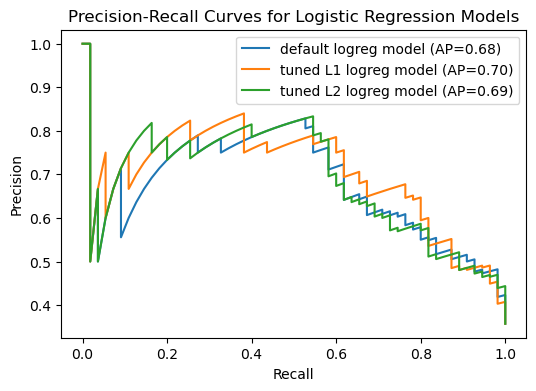

In [62]:
# precision recall curves of the test data for three logistic regression models

# get precision-recall values for each model
precision_lr,recall_lr,_ = precision_recall_curve(y_test,y_test_proba_baselr[:,1])
precision_l1,recall_l1,_ = precision_recall_curve(y_test,y_test_proba_l1[:,1])
precision_l2,recall_l2,_ = precision_recall_curve(y_test,y_test_proba_l2[:,1])

# calculate the average precision (AP) scores for each model
ap_lr = average_precision_score(y_test,y_test_proba_baselr[:,1])
ap_l1 = average_precision_score(y_test,y_test_proba_l1[:,1])
ap_l2 = average_precision_score(y_test,y_test_proba_l2[:,1])

# plot
plt.figure(figsize=(6,4))

plt.plot(recall_lr,precision_lr,label=f'default logreg model (AP={ap_lr:.2f})')
plt.plot(recall_l1,precision_l1,label=f'tuned L1 logreg model (AP={ap_l1:.2f})')
plt.plot(recall_l2,precision_l2,label=f'tuned L2 logreg model (AP={ap_l2:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Logistic Regression Models')

plt.legend()
plt.show()

For a classification model to predict diabetes, recall is the more important metric. Precision is the number of tp/(tp+fp), while recall is the number of tp/(tp+fn). A higher recall score means that fewer false negatives are predicted, and therefore, fewer people who do have diabetes would remain unidentified. The consequences of untreated diabetes is greater than treating someone without diabetes.

Since recall is most significant here, the tuned logistic regression model with L1 regularization performs the best and significantly better than the the logistic regression model with default hyperparameters.

The ROC curves and AUC scores suggest that all models perform reasonbly well and about the same with regard to distinguishing true positives from false positives. However, the tuned logreg model with L1 regularization performed the best of the three models based on the curve and AUC score.

The precision-recall curves are useful here since the number of postivive cases (1s) for diabetes is ~30% of the total outcomes and correctly identifying those at risk for diabetes is more important than predicting no diabetes. An AP score of 0.70 isn't great but suggests that the model is capturing a significant portion of the postive instances with a reasonable level of precision.

Conclusion: There is room for improvement.

In [65]:
# visualize feature importance for the logistic regression model

# get feature names:
feature_names = X_train.columns.tolist()
    
# extract coefficients
coefficients_l1_lr = best_model_l1_lr.coef_[0]

# create a dataframe to associate featuers with their coefficients
feature_importance_l1_lr = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients_l1_lr
})

# sort by absolute value of coefficients
feature_importance_l1_lr['abs_coefficient'] = feature_importance_l1_lr['coefficient'].abs()
feature_importance_l1_lr = feature_importance_l1_lr.sort_values(by='abs_coefficient',ascending=False)

feature_importance_l1_lr

,feature,coefficient,abs_coefficient
14,Age,-67.539467,67.539467
11,AgeSqrd,44.047562,44.047562
5,GlucoseXAge,34.333327,34.333327
7,InsulinXBMI,16.092435,16.092435
3,Insulin,-14.135135,14.135135
0,Glucose,-10.148612,10.148612
4,BMI,-8.676565,8.676565
10,GlucoseSqrd,-7.102329,7.102329
23,InsulinBins_InuslinLow,6.106954,6.106954
9,BMISqrd,3.754685,3.754685


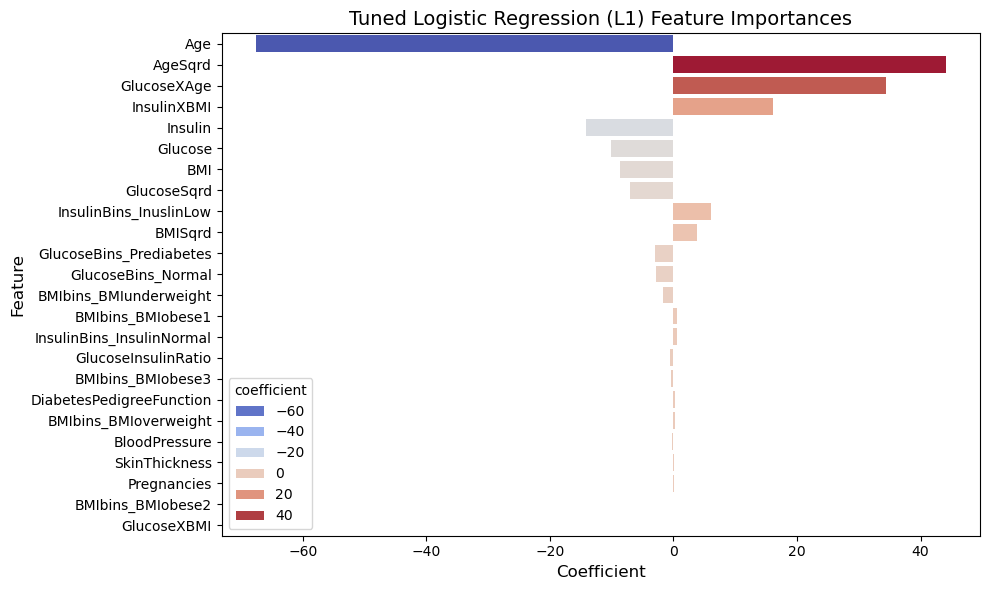

In [73]:
featimp = feature_importance_l1_lr

plt.figure(figsize=(10, 6))
sns.barplot(
    x='coefficient',
    y='feature',
    hue='coefficient',
    data=featimp,
    palette='coolwarm',
    orient='h', 
)
plt.title('Tuned Logistic Regression (L1) Feature Importances', fontsize=14)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

The presence of 'age' at the top of the feature importance list is a bit suprising based on EDA results in the first notebook.  Mainly, glucose was seen to be most correlated with outcome at 0.47, while age was not well correlated at 0.24.  Glucose does show up as in important feature as an interaction with age and, to some extent, by itself.  It will be interesting to see what features are most important for other models.  

Also, GlucosexBMI was likely selected out of the model with L1 regularization.  

# Summary of the Logistic Regerssion Model Performance

- Model Performance:

The L1-regularized model performed best overall, achieving the highest test ROC-AUC (0.831) and test AP score (0.70).

- Classification Reports & Class Imbalance Impact:

Precision for class 1 (diabetes) was consistently lower (~ 0.57–0.63) than for class 0 (~ 0.83–0.86), indicating higher false positives for the positive class.

Recall for class 1 was higher (~ 0.75–0.80) than for class 0 (~ 0.69–0.75), suggesting the model is better at identifying true positives but at the cost of more false negatives for class 0.

- Confusion Matrices:

L1 model reduced false negatives (11 vs. 12 in default) and false positives (29 vs. 31 in default) on the test set.

- Feature Importance (L1 Model):

Top 5 influential features (by absolute coefficient):

Age (-67.54)

AgeSqrd (44.05)

Glucose×Age (34.33)

Insulin×BMI (16.09)

Insulin (-14.14)